This code is used to split dataset that has labels

In [ ]:
import os
import shutil
import random
from pathlib import Path

# image path
path = './data/Foot Ulcer Segmentation Challenge/data new/'
# data folders
datafolders = ['train/', 'validation/', 'test/']
# subfolders
subfolders = ['images/', 'labels/']

filesAll = os.listdir(path+subfolders[0])

images = [file for file in filesAll if file.endswith('png')]

random.shuffle(images)


train_size = 0.7
valid_size = 0.2

train_index = int(len(images)*train_size)
valid_index = int(len(images)*(valid_size+train_size))

for i, image in enumerate(images):
    if i < train_index:
        main_path = path + datafolders[0]
    elif i > train_index and i < valid_index:
        main_path = path + datafolders[1]
    else:
        main_path = path + datafolders[2]
    shutil.copy(path+subfolders[0]+image, main_path+subfolders[0]+image)
    shutil.copy(path+subfolders[1]+image, main_path+subfolders[1]+image)   






Augmentation parameter definition.

In [3]:
import cv2
import imgaug.augmenters as iaa
import numpy as np

def calcGamma(gamma):
        invGamma = 1 / gamma
        table = [((i / 255) ** invGamma) * 255 for i in range(256)]
        table = np.array(table, np.uint8)
        return table
def gammaCorrection(image, gamma, iterations):
        decrement = gamma/iterations
        param = gamma       
        results = {}
        count = iterations * 2 + 1
        # print(count)
        for i in range(count):
            scl = 1+param
            if round(scl, 1) == 1.0: #when param is 1.0
                results['-1-'] = image
            else:
                table = calcGamma(scl)
                results[i] = cv2.LUT(image, table)
            param -= decrement
        return results

techniques ={
    'contrast'          :   iaa.GammaContrast,          # gamma
    'brightness'        :   iaa.MultiplyBrightness,     # (sc, sc)
    'saturation'        :   iaa.MultiplySaturation,     # (sc, sc)
    'gaussian_blur'     :   iaa.GaussianBlur,           # sigma
    #'gamma_correction'  :   gammaCorrection,            # gamma
    'flip'              :   cv2.flip,                       # flip type
    'rotation'          :   iaa.Rotate,                 # (angle, angle)
    'shift'             :   [iaa.TranslateX, iaa.TranslateY],             # (angle, angle)
    'sharpen'           :   iaa.Sharpen,                # alpha
    'scale'             :   iaa.Affine,                 # scale
    'crop'              :   iaa.CropAndPad,             # scale
    'shear'             :   [iaa.ShearX, iaa.ShearY],                        # scale
}

parameters = {
    'contrast'          : {
                           'type'       : 'iterate',
                           'range'      : 0.3,
                           'base'       : 1,
                           'label'      : False,
                           'parameter'  : 'gamma',
                           'iterations' : [1, 2]},
    'brightness'        : {
                           'type'       : 'iterate',
                           'range'      : 0.3,
                           'base'       : 1,
                           'label'      : False,
                           'parameter'  : 'mul',
                           'iterations' : [1, 2]},
    'saturation'        : {
                           'type'       : 'iterate',
                           'range'      : 0.3,
                           'base'       : 1,
                           'label'      : False,
                           'parameter'  : 'mul',
                           'iterations' : [1, 2]},
    'gaussian_blur'     : {
                           'type'       : 'iterate',
                           'range'      : 1.5,
                           'base'       : 1.5,
                           'label'      : False,
                           'parameter'  : 'sigma',
                           'iterations' : [1, 2]},
    'gamma_correction'  : {
                           'type'       : 'iterate-custom',
                           'range'      : 0.3,
                           'base'       : 1,
                           'label'      : False,
                           'parameter'  : 'gamma',
                           'iterations' : [1, 2]},
    'flip'              : {
                           'type'       : 'sequential',
                           'label'      : True,
                           'parameter'  : None,
                           'iterations' : [0, 1, 2]},
    'rotation'          : {
                           'type'       : 'iterate',
                           'range'      : 90,
                           'base'       : 0,
                           'label'      : True,
                           'parameter'  : 'rotate',
                           'iterations' : [1, 2]},
    'shift'            : {
                           'type'       : 'iterate-custom',
                           'parameter'  : 'percent',
                           'label'      : True,
                           'base'       : 0,
                           'range'      : 0.3,
                           'iterations' : [1, 2]},
    'sharpen'           : {
                           'type'       : 'iterate',
                           'parameter'  : 'alpha',
                           'base'       : 0.30,
                           'label'      : False,
                           'range'      : 0.30,
                           'iterations' : [1, 2]},
    'scale' : {
                           'type'       : 'iterate',                           
                           'parameter'  : 'scale',
                           'base'       : 1,
                           'label'      : True,
                           'range'      : 0.3,
                           'iterations' : [1, 2]},
    'crop' : {
                           'type'       : 'iterate',
                           'base'       : -0.15,
                           'range'      : 0.15,
                           'label'      : True,
                           'parameter'  : 'percent',
                           'iterations' : [1, 2]},
    'shear' : {
                           'type'       : 'iterate-custom',
                           'parameter'  : '',
                           'label'      : True,
                           'base'       : 0,
                           'range'      : 30,
                           'iterations' : [1, 2]},
}
    
def iterative(image, fx, paramName, paramValues, iterations):
    decrement = paramValues[1]/iterations
    param = paramValues[1]   
    
    results = {}
    count = iterations * 2 + 1
    # print(count)
    for i in range(count):
        scl = paramValues[0]+param
        if round(scl, 1) == paramValues[0]: #when param is 1.0
            results['-1-'] = image
        else:
            aug = fx(**{paramName : (scl, scl)})
            results[i] = aug(image = image)
        param -= decrement
        # print(i)
    return results

def iterative2D(image, fxs, paramName, paramValues, iterations):
    decrement = paramValues[1]/iterations
    paramX = paramValues[1]
    num = 0 
    results = {}
    count = iterations * 2 + 1
    # print(count)
    for i in range(count):
        sclX = paramValues[0]+paramX                        
        paramY = paramValues[1]
        for j in range(count):
            sclY = paramValues[0]+paramY
            if round(sclX, 1) == paramValues[0] and round(sclY, 1) == paramValues[0]: #when param is 1.0
                results['-1-'] = image
            else:
                try:
                    aug = iaa.Sequential([
                    fxs[0](**{paramName : (sclX, sclX)}),
                    fxs[1](**{paramName : (sclY, sclY)})])
                except:
                    aug = iaa.Sequential([
                    fxs[0]((sclX, sclX)),
                    fxs[1]((sclY, sclY))])
                results[num] = aug(image = image)
            num += 1
            paramY -= decrement
        paramX -= decrement
        # print(i)
    return results

Augmentation routine

In [7]:
from pathlib import Path
import os
import cv2
# root folder
srcFolder = './data/Foot Ulcer Segmentation Challenge/data new/train/'
# destination folder
dstFolder = './data/Foot Ulcer Segmentation Challenge/data new/augmented/'
# subfolders
subfolders = ['images', 'labels']
# image list
images = os.listdir(srcFolder+subfolders[0])
# print(images)

def saveImages(augmentations, image, saveDirectory, keepLabel = False):
    # save every new image
    for augmImage in list(augmentations.keys()):
        if augmImage !='-1-':
            suffix = '-'+str(augmImage)
        else:
            suffix = ''
        # do not augment color transforms
        if keepLabel:
            saveImage = image
        else:
            saveImage = augmentations[augmImage]
        # create directory if not exists
        savePath = saveDirectory+imageName.replace('.png', suffix+'.png')
        # print(savePath)
        cv2.imwrite(savePath, saveImage)


# for every augmentation method
for method in list(techniques.keys()):
    # if method is iterative
    params = parameters[method]
# for every iteration
    for iteration in parameters[method]['iterations']:
        # for every image in directory
        for subfolder in subfolders:
            saveDirectory = dstFolder + method+'_'+str(iteration)+'/'+subfolder+'/'
            if not os.path.exists(saveDirectory):
                Path(saveDirectory).mkdir(parents=True, exist_ok=True)
            else: continue
            for imageName in images:
                imageDir = srcFolder+subfolder+'/'+imageName
                image = cv2.imread(imageDir)
                if params['type'] == 'iterate':
                    augmentations = iterative(image, 
                                            techniques[method], 
                                            params['parameter'], 
                                            [params['base'], params['range']], 
                                            iteration)
                elif method == 'gamma_correction':                    
                    augmentations = {}
                    augmentations = gammaCorrection(image, params['range'], iteration)                        
                elif method == 'flip':
                    augmentations = {}
                    augmentations['-1-'] = image
                    flip = techniques[method]
                    if iteration > 1:
                        augmentations[0]=flip(image, 0)
                        augmentations[1]=flip(image, 1)
                        augmentations[2]=flip(flip(image, 0), 1)
                    else:
                        augmentations[iteration]=flip(image, iteration)
                elif method == 'shift':
                    augmentations = iterative2D(image, 
                                            techniques[method], 
                                            params['parameter'], 
                                            [params['base'], params['range']], 
                                            iteration)
                elif method == 'shear':
                    augmentations = iterative2D(image, 
                                        techniques[method], 
                                        params['parameter'], 
                                        [params['base'], params['range']], 
                                        iteration)              
                      
                
                keepLabel = subfolder is subfolders[1] and not params['label']
                saveImages(augmentations, image, saveDirectory, keepLabel)
            



Reshuffle augmented images to create ensemble datasets. 5 best performing techniques will be used.

In [7]:
import os
import shutil
import itertools as iter


# image path
path = './data/Foot Ulcer Segmentation Challenge/data new/augmented/'
# best performers
datafolders = ["shear_1", "crop_2", "scale_2", "rotation_2", "flip_2"]
# subfolders
subfolders = ['images/', 'labels/']

# get all possible combination with 2 and 3 elements
combs = \
    list(iter.combinations(datafolders, 2)) +\
    list(iter.combinations(datafolders, 3))

#iterate through all combinations
for comb in combs:
    #destination directory
    newFolder = '_'.join(comb) + '/'
    #go through image and label folders
    for subfolder in subfolders:
        #flag that ensures that original image is only copied once
        #original does not have any suffix number
        origPresent = False  
        #every folder in combination
        for folder in comb:
            #go through every file
            srcPath = path + folder + '/' + subfolder
            dstPath = path + newFolder + subfolder
            #create new directory
            if not os.path.exists(dstPath):
                Path(dstPath).mkdir(parents=True, exist_ok=True)

            #go through all files in the src directory
            for file in os.listdir(srcPath):
                #take only images
                if not file.endswith('png'):
                    continue
                #dash '-' indicates that it is an augmented image
                if not '-' in file and origPresent:
                    continue
                
                #set the flag
                if not '-' in file:
                    origPresent = True
                #copy files to new directory and add prefix indicating the file source
                shutil.copy(srcPath + file, dstPath + folder + '_' + file)
        






Training loop

Progress: 3.4482758620689653%
Progress: 6.896551724137931%
Progress: 10.344827586206897%
Progress: 13.793103448275861%
Progress: 17.24137931034483%
Progress: 20.689655172413794%
Progress: 24.137931034482758%
Progress: 27.586206896551722%
Progress: 31.03448275862069%
Progress: 34.48275862068966%
Progress: 37.93103448275862%
Progress: 41.37931034482759%
Progress: 44.827586206896555%
Progress: 48.275862068965516%
Progress: 51.724137931034484%
Progress: 55.172413793103445%
Progress: 58.620689655172406%
Progress: 62.06896551724138%
Progress: 65.51724137931035%
Progress: 68.96551724137932%
Progress: 72.41379310344827%
Progress: 75.86206896551724%
Progress: 79.3103448275862%
Progress: 82.75862068965517%
Epoch 1/2000
1060/1060 [==============================] - 273s 255ms/step - loss: 0.0810 - dice_coef: 0.1282 - precision: 0.4389 - recall: 0.1174 - val_loss: 0.0245 - val_dice_coef: 0.6060 - val_precision: 0.8014 - val_recall: 0.5093
Epoch 2/2000
1060/1060 [==============================] - 27

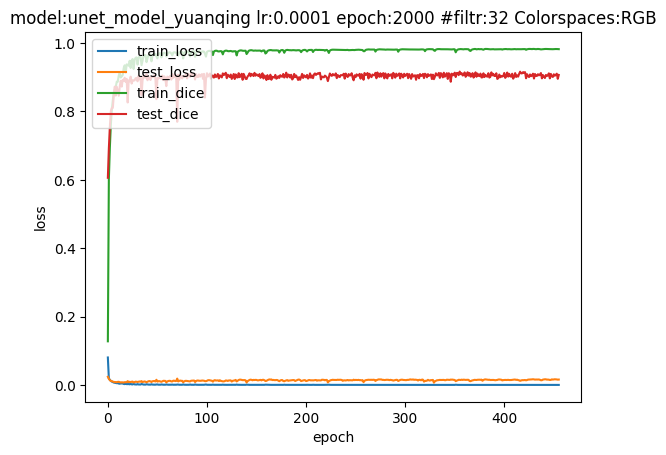

Progress: 86.20689655172413%
Epoch 1/2000
1414/1414 [==============================] - 500s 352ms/step - loss: 0.0638 - dice_coef: 0.2897 - precision: 0.4987 - recall: 0.2514 - val_loss: 0.0230 - val_dice_coef: 0.6203 - val_precision: 0.8589 - val_recall: 0.5164
Epoch 2/2000
1414/1414 [==============================] - 338s 239ms/step - loss: 0.0182 - dice_coef: 0.6596 - precision: 0.8137 - recall: 0.5842 - val_loss: 0.0180 - val_dice_coef: 0.6796 - val_precision: 0.8634 - val_recall: 0.5826
Epoch 3/2000
1414/1414 [==============================] - 338s 239ms/step - loss: 0.0132 - dice_coef: 0.7638 - precision: 0.8492 - recall: 0.7128 - val_loss: 0.0124 - val_dice_coef: 0.7927 - val_precision: 0.9373 - val_recall: 0.6981
Epoch 4/2000
1414/1414 [==============================] - 337s 238ms/step - loss: 0.0108 - dice_coef: 0.8082 - precision: 0.8679 - recall: 0.7702 - val_loss: 0.0095 - val_dice_coef: 0.8631 - val_precision: 0.8636 - val_recall: 0.8699
Epoch 5/2000
1414/1414 [===========

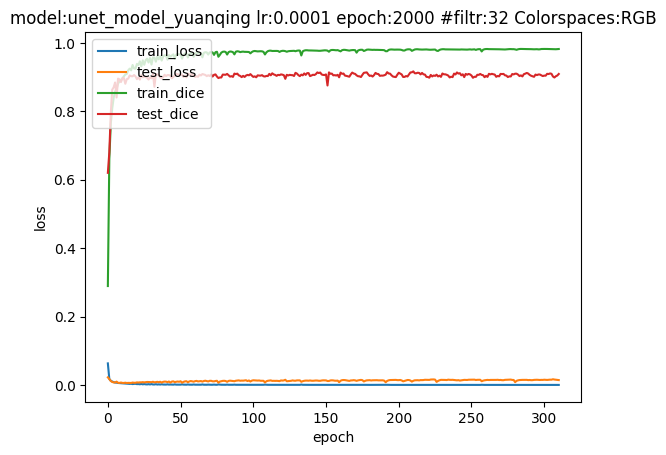

Progress: 89.65517241379311%
Progress: 93.10344827586206%
Progress: 96.55172413793103%
Progress: 100.0%


<Figure size 640x480 with 0 Axes>

In [7]:
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, CSVLogger
from keras.backend import clear_session

from models.unets import Unet2D

from utils.learning.metrics import dice_coef, precision, recall
from utils.io.data import DataGen, save_history

import os
import tensorflow as tf

# clear training session
clear_session()

# training parameters
batch_size = 8
epochs = 2000
learning_rate = 1e-4
loss = 'binary_crossentropy'

# Model parameters
input_dim_x=512
input_dim_y=512
n_filters = 32

#path variables
testPath = './data/Foot Ulcer Segmentation Challenge/data new/'
srcPath = './data/Foot Ulcer Segmentation Challenge/data new/augmented/'
historyFolder = './training_history/data new/'
dataset = 'Foot Ulcer Segmentation Challenge'

# for every augmentation method train a network
augmFolders = os.listdir(srcPath)
hist_files = [file.replace('.json','') for file in os.listdir(historyFolder) if file.endswith('.json')]
for i, folder in enumerate(augmFolders):
    print(f'Progress: {(i+1)/len(augmFolders)*100}%')
    #only train if not done before
    if folder in hist_files:
        continue
    
    trainPath = srcPath + folder + '/'    
    
    #random seed to get uniform initialization
    tf.keras.utils.set_random_seed(100)
    
    #data generator
    data_gen = DataGen(testPath, trainPath, split_ratio=0.0, x=input_dim_x, y=input_dim_y)

    #model definition
    unet2d = Unet2D(n_filters=n_filters, input_dim_x=None, input_dim_y=None, num_channels=3)
    model, model_name = unet2d.get_unet_model_yuanqing()

    es = EarlyStopping(monitor='val_dice_coef', patience=100, mode='max', restore_best_weights=True)
    csv_logger = CSVLogger(historyFolder+folder+'.csv', separator = ';')

# AK: avoid outputing model summary
    # model.summary()

    model.compile(optimizer=Adam(lr=learning_rate), loss=loss, metrics=[dice_coef, precision, recall])
    training_history = model.fit(data_gen.generate_data(batch_size=batch_size, train=True),
                                        steps_per_epoch=int(data_gen.get_num_data_points(train=True) / batch_size),
                                        callbacks=[es, csv_logger],
                                        validation_data=data_gen.generate_data(batch_size=batch_size, val=True),
                                        validation_steps=int(data_gen.get_num_data_points(val=True) / batch_size),
                                        epochs=epochs,
                                        shuffle = False)

    # save the model weight file and its training history
    save_history(model, model_name, training_history, dataset, n_filters, epochs, learning_rate, loss, color_space='RGB',
                path=historyFolder, temp_name = folder)

    # Added to clear session and restore Keras
    clear_session()
   

Prediction and evaluation

In [1]:
from keras.models import load_model
from tensorflow import keras


from keras.backend import clear_session


from models.unets import Unet2D
from models.deeplab import relu6, BilinearUpsampling, DepthwiseConv2D

from utils.learning.metrics import dice_coef, precision, recall
from utils.io.data import save_results, DataGen
import os
import csv


#model parameters
input_dim_x=512
input_dim_y=512
n_filters = 32
#testing parameters
batch_size = 8
#model definition
unet2d = Unet2D(n_filters=n_filters, input_dim_x=None, input_dim_y=None, num_channels=3)
model, model_name = unet2d.get_unet_model_yuanqing()

# directories
srcPath = './data/Foot Ulcer Segmentation Challenge/data new/augmented/'
dstPath = './data/Foot Ulcer Segmentation Challenge/data new/test/predictions/'
dataset = 'Foot Ulcer Segmentation Challenge'
history = './training_history/data new/'

#go through all augmentation folders
augmFolders = os.listdir(srcPath)
hist_files = [file.replace('.hdf5','') for file in os.listdir(history) if file.endswith('.hdf5')]
for i, folder in enumerate(augmFolders):
    print(f'Progress: {(i+1)/len(augmFolders)*100}%')
    #only train if not done before
    if folder in os.listdir(dstPath):
        continue
    
    #clear GPU
    clear_session()
    
    trainPath = srcPath+folder+'/'
    testPath = './data/'+dataset+'/data new/'
    # print(f'Train path: {trainPath}, Test path: {testPath}')       
    
    data_gen = DataGen(testPath, trainPath, split_ratio=0.0, x=input_dim_x, y=input_dim_y)

    #load weights
    model = load_model('./training_history/data new/' + folder+'.hdf5'
                , custom_objects={'recall':recall,
                                    'precision':precision,
                                    'dice_coef': dice_coef,
                                    'relu6':relu6,
                                    'DepthwiseConv2D':DepthwiseConv2D,
                                    'BilinearUpsampling':BilinearUpsampling})
    precisions = keras.metrics.Precision()
    recalls = keras.metrics.Recall()
    for image_batch, label_batch in data_gen.generate_data(len(data_gen.y_test_file_list), test=True):
        prediction = model.predict(image_batch, verbose=1)
        
        precisions.update_state(label_batch,prediction)
        recalls.update_state(label_batch,prediction)
        
        prec = precisions.result().numpy()
        rec = recalls.result().numpy()
        dice = 2*(prec*rec)/(prec+rec)
        
        os.mkdir(dstPath + folder)
        save_results(prediction, 'rgb', dstPath + folder+"/", data_gen.y_test_file_list)
        break
    with open(dstPath + 'dice.csv', 'a') as csv_file:  
        writer = csv.writer(csv_file)
        writer.writerow([folder, dice])


Progress: 3.4482758620689653%
Progress: 6.896551724137931%
Progress: 10.344827586206897%
Progress: 13.793103448275861%
Progress: 17.24137931034483%
Progress: 20.689655172413794%
Progress: 24.137931034482758%
Progress: 27.586206896551722%
Progress: 31.03448275862069%
Progress: 34.48275862068966%
Progress: 37.93103448275862%
Progress: 41.37931034482759%
Progress: 44.827586206896555%
Progress: 48.275862068965516%
Progress: 51.724137931034484%
Progress: 55.172413793103445%
Progress: 58.620689655172406%
Progress: 62.06896551724138%
Progress: 65.51724137931035%
Progress: 68.96551724137932%
Progress: 72.41379310344827%
4/4 [==============================] - 10s 732ms/step
Progress: 75.86206896551724%
4/4 [==============================] - 1s 342ms/step
Progress: 79.3103448275862%
4/4 [==============================] - 1s 324ms/step
Progress: 82.75862068965517%
4/4 [==============================] - 1s 337ms/step
Progress: 86.20689655172413%
4/4 [==============================] - 1s 346ms/step

Now let's try to use different dataset. It contains smaller images, so upsampling should be used first.

In [24]:
import os
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator

# directories
srcFolder = os.path.abspath('./data/Medetec_foot_ulcer_224/train/')
dstFolder = os.path.abspath('./data/Medetec_foot_ulcer_224/upsample/train/')

# subfolders
subfolders = ['\\images', '\\labels']

# data generator with resize
data_generator = ImageDataGenerator(#rescale=1./255,  # Normalize pixel values (optional)
                                   preprocessing_function=lambda x: x.resize((512, 512)))

#the generators
image_generator = data_generator.flow_from_directory(srcFolder+subfolders[0],
                                                    target_size=(512, 512),
                                                    class_mode='input',
                                                    shuffle=False,
                                                    batch_size=1)

label_generator = data_generator.flow_from_directory(srcFolder+subfolders[1],
                                                    target_size=(512, 512),
                                                    class_mode='input',
                                                    shuffle=False,
                                                    batch_size=1)

# create destination directories
for subfolder in subfolders:    
    if not os.path.exists(dstFolder+subfolder):
        os.makedirs(dstFolder+subfolder)


print(image_generator.filepaths)

#save each image
for i in range(len(image_generator.filenames)):
    image = image_generator.next()
    label = label_generator.next()

    image_path = os.path.join(dstFolder+subfolders[0], image_generator.filenames[i])
    label_path = os.path.join(dstFolder+subfolders[1], label_generator.filenames[i])

    data_generator.save_img(image_path, image[0])
    data_generator.save_img(label_path, label[0])

    
    


Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
[]


In [3]:
import os


full_path = os.path.abspath(srcFolder)

print("Full path:", full_path)


Full path: d:\AKairys\Augmentation analysis\Augmentation test\wound-segmentation\Augmentation-test\data\Medetec_foot_ulcer_224\train
